# Load data

In [1]:
!wget -O Data.npz https://zenodo.org/record/4269852/files/dermamnist.npz?download=1

--2021-08-14 19:09:46--  https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19725078 (19M) [application/octet-stream]
Saving to: ‘Data.npz’

Data.npz            100%[===================>]  18.81M  8.66MB/s    in 2.2s    

2021-08-14 19:09:49 (8.66 MB/s) - ‘Data.npz’ saved [19725078/19725078]



In [2]:
import matplotlib.pyplot as plt   
import numpy as np
import matplotlib.image as mpimg
import cv2
from tensorflow.keras.utils import to_categorical

In [3]:
d = np.load('Data.npz')
print(d.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [4]:
print(d['train_labels'].shape)

(7007, 1)


Train: X=(7007, 28, 28, 3), y=(7007, 1)
Test: X=(2005, 28, 28, 3), y=(2005, 1)


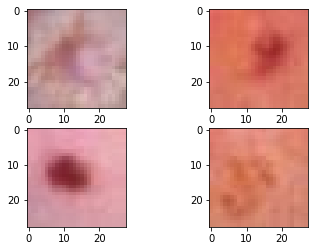

In [5]:
print('Train: X=%s, y=%s' % (d['train_images'].shape, d['train_labels'].shape))
print('Test: X=%s, y=%s' % (d['test_images'].shape, d['test_labels'].shape))
# plot some images
for i in range(4):
	plt.subplot(220 + 1 + i)
	plt.imshow(d['train_images'][i])
plt.show()

In [6]:
data = {key: d[key] for key in d.files}

In [7]:
data['train_images'][0].shape

(28, 28, 3)

# Preprocessing

In [8]:
# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

## Resize Images
## Remove noise(Denoise)


In [9]:
# resize images
def resize_image(data):
    img = data
    print(len(img))
    print('Original size',img[0].shape)
    # setting dim of the resize
    height = 32
    width = 32
    dim = (width, height)
    res_img = []
    for i in range(len(img)):
        res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
        res_img.append(res)

    # Checcking the size
    print("RESIZED", res_img[0].shape)
    
    # Visualizing one of the images in the array
    original = res_img[0]
    display_one(original)

    # Remove noise
    # Gaussian
    #no_noise = []
    #for i in range(len(res_img)):
    #  blur = cv2.GaussianBlur(res_img[i], (5, 5), 0)
    #  no_noise.append(blur)

    #image = no_noise[0]
    #display(original, image, 'Original', 'Blured')

    return np.array(res_img)

7007
Original size (28, 28, 3)
RESIZED (32, 32, 3)


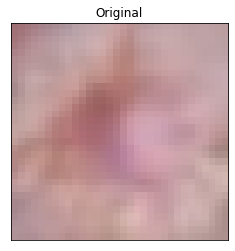

1003
Original size (28, 28, 3)
RESIZED (32, 32, 3)


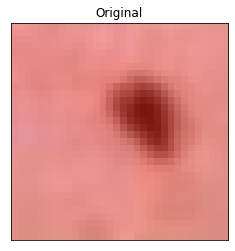

2005
Original size (28, 28, 3)
RESIZED (32, 32, 3)


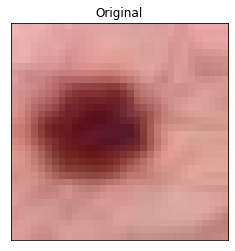

In [10]:
# Resize all images
data = dict({key: resize_image(data[key]) for key in d.files[:3]}, **{key: data[key] for key in d.files[3:]})

In [11]:
data['val_images'][6].shape

(32, 32, 3)

# Image Data Generator

In [306]:
from keras.preprocessing.image import ImageDataGenerator

In [307]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=10,
    height_shift_range=10,
    brightness_range=(0.3, 1.8),
    shear_range=5,
    zoom_range=0.2,
    fill_mode = 'wrap',
    horizontal_flip = True,
    validation_split=0.2,
)

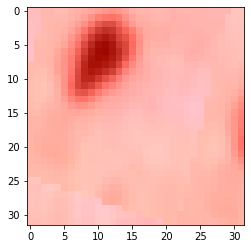

In [308]:
image = data['val_images'][0].reshape((-1,) + data['val_images'][0].shape)
train_gen = datagen.flow(image, [0], batch_size=1, shuffle=False)
X, y = train_gen.next()
plt.imshow(X[0].astype(np.uint8))

train_imgs, train_labels = [], []
for image, label in zip(data['train_images'], data['train_labels']):
  image = image.reshape((-1,) + image.shape)
  rain_gen = datagen.flow(image, [0], batch_size=1, shuffle=False)
  X, y = train_gen.next()
  train_imgs.append(X[0].astype(np.uint8))
  train_labels.append(label)

In [309]:
data['train_images'] = np.concatenate([np.array(train_imgs), data['train_images']])
data['train_labels'] = np.concatenate([np.array(train_labels), data['train_labels']])

In [310]:
data['train_images'].shape

(14014, 32, 32, 3)

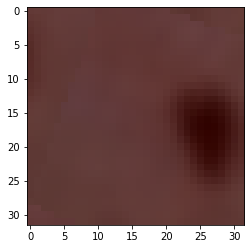

In [311]:
plt.imshow(train_imgs[1])

In [312]:
X[0].astype(np.uint8).shape

(32, 32, 3)

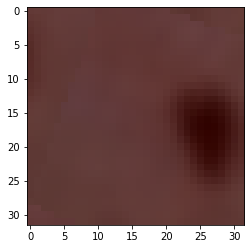

In [313]:
plt.imshow(data['train_images'][1].astype(np.uint8))

# Concat train, val and test, then shuffle and split

In [12]:
combined_images = np.concatenate([data['train_images'], data['val_images'], data['test_images']])
combined_labels = np.concatenate([data['train_labels'], data['val_labels'], data['test_labels']])

In [13]:
combined_images.shape

(10015, 32, 32, 3)

In [14]:
c = np.c_[combined_images.reshape(len(combined_images), -1), combined_labels.reshape(len(combined_labels), -1)]

In [15]:
np.random.shuffle(c)

In [16]:
shuffled_images = c[:, :combined_images.size//len(combined_images)].reshape(combined_images.shape)
shuffled_labels = c[:, combined_images.size//len(combined_images):].reshape(combined_labels.shape)

In [17]:
shuffled_images.shape

(10015, 32, 32, 3)

In [18]:
shuffled_labels.shape

(10015, 1)

[2]


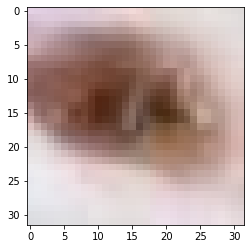

In [19]:
plt.imshow(shuffled_images[0])
print(shuffled_labels[0])

In [20]:
# split train, val and test
[data['train_images'], data['val_images'], data['test_images']] = np.split(shuffled_images, [int(.4 * len(shuffled_images)), int(.7 * len(shuffled_images))])
[data['train_labels'], data['val_labels'], data['test_labels']] = np.split(shuffled_labels, [int(.4 * len(shuffled_labels)), int(.7 * len(shuffled_labels))])

In [21]:
for tag in list(data.keys())[:3]:
  # convert from integers to floats
  data[tag] = data[tag].astype('float32')
  # normalize to range 0-1
  data[tag] /= 255

# one hot y values
for tag in list(data.keys())[3:]:
  data[tag] = to_categorical(data[tag])

In [22]:
data['test_images'].shape

(3005, 32, 32, 3)

# VGG Model

In [23]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *

In [32]:
model = Sequential()

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=data['train_images'][0].shape, kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform'))
model.add(MaxPool2D((4, 4), strides=(2, 2)))
model.add(Dropout(0.05))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model.add(MaxPool2D((4, 4), strides=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model.add(MaxPool2D((4, 4), strides=(2, 2)))
model.add(Dropout(0.05))

model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform'))
model.add(Dropout(0.05))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 256)       295168    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 256)       590080    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 256)        

In [33]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

In [34]:
history = model.fit(data['train_images'], data['train_labels'], batch_size=32, epochs=30, validation_data=(data['val_images'], data['val_labels']))

Epoch 1/30
126/126 [==============================] - 4s 28ms/step - loss: 3.1629 - acc: 0.6553 - val_loss: 2.8847 - val_acc: 0.6648
Epoch 2/30
126/126 [==============================] - 3s 26ms/step - loss: 2.7252 - acc: 0.6658 - val_loss: 2.5965 - val_acc: 0.6791
Epoch 3/30
126/126 [==============================] - 3s 26ms/step - loss: 2.5000 - acc: 0.6750 - val_loss: 2.4300 - val_acc: 0.6801
Epoch 4/30
126/126 [==============================] - 3s 25ms/step - loss: 2.3344 - acc: 0.6840 - val_loss: 2.3125 - val_acc: 0.6694
Epoch 5/30
126/126 [==============================] - 3s 26ms/step - loss: 2.2130 - acc: 0.6887 - val_loss: 2.1501 - val_acc: 0.6894
Epoch 6/30
126/126 [==============================] - 3s 26ms/step - loss: 2.1008 - acc: 0.6937 - val_loss: 2.0690 - val_acc: 0.6858
Epoch 7/30
126/126 [==============================] - 3s 26ms/step - loss: 2.0047 - acc: 0.7029 - val_loss: 2.0037 - val_acc: 0.6974
Epoch 8/30
126/126 [==============================] - 3s 26ms/step - 

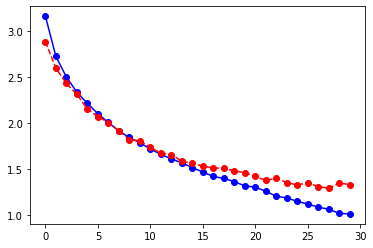

In [35]:
plt.plot(history.history['loss'], 'b-o')
plt.plot(history.history['val_loss'], 'r--o')

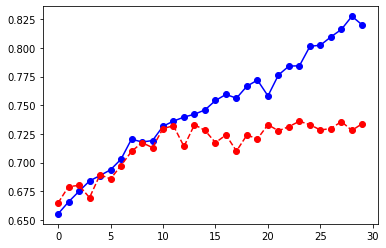

In [37]:
plt.plot(history.history['acc'], 'b-o')
plt.plot(history.history['val_acc'], 'r--o')

In [38]:
model.evaluate(data['test_images'], data['test_labels'])

94/94 [==============================] - 1s 8ms/step - loss: 1.2763 - acc: 0.7494


[1.276321530342102, 0.7494176626205444]

[[  12    2    6    4    3    0    0]
 [  33  110   52   17   14   25    3]
 [  15   13  130    2   34   60    0]
 [   0    0    0    0    0    0    0]
 [   1    1    5    1   59   17    2]
 [  18   27  134   10  230 1929   12]
 [   0    0    1    0    5    6   12]]


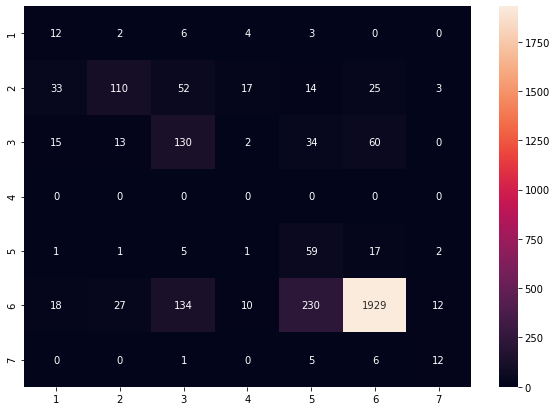

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import pandas as pd
import seaborn as sn


pred_test_values = np.argmax(model.predict(data['test_images']), axis=1)
y_test_arg = np.argmax(data['test_labels'], axis=1)

cm = confusion_matrix(pred_test_values, y_test_arg)
print(cm)

target_labels = '1234567'
df_cm = pd.DataFrame(cm, index = [i for i in target_labels],
                  columns = [i for i in target_labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

In [40]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(y_test_arg, pred_test_values, target_names=target_labels, digits=4))

              precision    recall  f1-score   support

           1     0.4444    0.1519    0.2264        79
           2     0.4331    0.7190    0.5405       153
           3     0.5118    0.3963    0.4467       328
           4     0.0000    0.0000    0.0000        34
           5     0.6860    0.1710    0.2738       345
           6     0.8174    0.9470    0.8774      2037
           7     0.5000    0.4138    0.4528        29

    accuracy                         0.7494      3005
   macro avg     0.4847    0.3999    0.4025      3005
weighted avg     0.7273    0.7494    0.7128      3005



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
